In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import datetime
import gc

In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from  sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV

#Выгрузка на Google disk

In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/data_test_isFraud_31_01.csv'
data_test = pd.read_csv(path_to_data)
data_test.head()

In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/data_train_full_isFraud_31_01.csv'
data_train_full = pd.read_csv(path_to_data)
data_train_full.head()

#Работа на разделение фичей

In [ ]:
# divide columns into categories
def div_col (data, tresh=4):
  list=data.columns
  numeric_features=[]
  features_cat = []
  feature_label=[]
  not_find=[]
  for col in list:
    if data[col].dtype == np.object:
      if len(data[col].unique())>tresh:
        feature_label.append(col)
      else:
        features_cat.append(col) 
    elif data[col].dtype == np.float64 or data[col].dtype ==np.int:
      numeric_features.append(col)
    else:    
      not_find.append(col)
  return numeric_features, features_cat, feature_label, not_find  

In [ ]:
numeric_features_x, features_cat_x, feature_label_x, not_find_x=div_col (X_test, tresh=4)

In [ ]:
features_cat_x

In [ ]:
feature_label_x

In [ ]:
list_name=[]
for col in data_test.columns:
  if not col in data_train_full.columns:
    #print ( col, ' - NOT')
    list_name.append(col)

In [ ]:
for col in list_name:
  #print ( col, ' - NOT', end=' ')
  col_n=col.split('-')[0]+'_'+col.split('-')[1]
  #print(col_n, '\n')
  data_test=data_test.rename(columns = {col: col_n})


In [ ]:
data_train['krit']=1
data_test['krit']=0
data_all=pd.concat([data_train, data_test], axis=0)

In [ ]:
data_all.shape

(650924, 473)

In [ ]:
numeric_features, features_cat, feature_label, not_find = div_col(data_all)

print('features_cat=',len(features_cat), 'numeric_features=', len(numeric_features), 'feature_label=', len(feature_label))

features_cat= 21 numeric_features= 403 feature_label= 10


In [ ]:
numeric_features_train, features_cat_train, feature_label_train, not_find = div_col(data_train_full)

print('features_cat=',len(features_cat_train), 'numeric_features=', len(numeric_features_train), 'feature_label=', len(feature_label_train))

features_cat= 21 numeric_features= 403 feature_label= 10


In [ ]:
not_find

[]

In [ ]:
numeric_features

In [ ]:
#feature_label

In [ ]:
#features_cat

In [ ]:
def look_at_feature (data, feature):
  for feat in feature:
    print(feat, '--', len(data[feat].unique()))

In [ ]:
#look_at_feature(data_all, feature_label)

In [ ]:
#look_at_feature(data_all, features_cat)

# Описание

Categorical Features  - Transaction
* ProductCD
* card1 - card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1 - M9
Categorical Features - Identity
* DeviceType
* DeviceInfo
* id_12 - id_38

Transaction Table *

TransactionDT: timedelta from a given reference datetime (not an actual timestamp)

* TransactionAMT: transaction payment amount in USD
* ProductCD: product code, the product for each transaction
* card1 - card6: payment card information, such as card type, card category,  issue bank, country, etc.
* addr: address
* dist: distance
* P_ and (R__) emaildomain: purchaser and recipient email domain
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: timedelta, such as days between previous transaction, etc.
* M1-M9: match, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
* ProductCD
* card1 - card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1 - M9

Identity Table *

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:
* DeviceType
* DeviceInfo
* id_12 - id_38

https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203

#Исследуем данные

## Корреляция

In [ ]:
correlations_data = data_train.corr()['isFraud'].sort_values()

In [ ]:
# Голова массива - минимальная корреляция
print(correlations_data.head(15), '\n')

# Хвост - максимальная корреляция
print(correlations_data.tail(15))

D5      -0.147260
D8      -0.142636
D7      -0.129077
id_01   -0.120099
D2      -0.102215
id_07   -0.084768
D10     -0.072737
V150    -0.064043
D15     -0.063428
V159    -0.062742
V160    -0.062408
V145    -0.062063
D6      -0.061721
V151    -0.060958
id_04   -0.059701
Name: isFraud, dtype: float64 

V30    NaN
V35    NaN
V36    NaN
V48    NaN
V49    NaN
V53    NaN
V54    NaN
V69    NaN
V70    NaN
V75    NaN
V76    NaN
V90    NaN
V91    NaN
V107   NaN
V305   NaN
Name: isFraud, dtype: float64


## Анализ фичей

Категорийные и числовые, полнота

In [ ]:
def analyse_column (data):
  col_nan=[]
  col_low=[]
  col_norm=[]
  l=data.shape[0]
  for col in data.columns:
    if (data[col].isna().sum()/l) ==1:
      col_nan.append(col)
    elif (data[col].isna().sum()/l)>0.6:
      col_low.append(col)  
    else:
      col_norm.append(col)
  return col_nan, col_low, col_norm  


In [ ]:
col_nan, col_low, col_norm = analyse_column(data_train_full)
print('col_nan- ', len(col_nan), 'col_low-', len(col_low), 'col_norm- ', len(col_norm))

col_nan-  0 col_low- 208 col_norm-  226


In [ ]:
def countity_of_col(data, feature):
  print('Инфо по фичам: ', feature)
  for col in feature:
    if col in col_nan:
      print('Пустые - ', col, '\n')
    elif col in col_low:
      print('Почти пустые', col,  ' - ', data[col].isna().mean(), '\n')
    else:
      print('Нормальные', col, ' - ', data[col].isna().mean(), '\n')
  return  

In [ ]:
countity_of_col(data_train_full, feature_label)

Инфо по фичам:  ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'id_30', 'id_31', 'id_33', 'id_34', 'DeviceInfo']
Нормальные ProductCD  -  0.0 

Нормальные card4  -  0.00267043722694483 

Нормальные card6  -  0.0026602770345785214 

Нормальные P_emaildomain  -  0.1599485216920107 

Почти пустые R_emaildomain  -  0.7675161716395164 

Почти пустые id_30  -  0.868654113184543 

Почти пустые id_31  -  0.7624513157449114 

Почти пустые id_33  -  0.8758949436109323 

Почти пустые id_34  -  0.8682477054898906 

Почти пустые DeviceInfo  -  0.7990551021099332 



In [ ]:
countity_of_col(data_train_full, features_cat)

Инфо по фичам:  ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType']
Нормальные M1  -  0.4590713584177194 

Нормальные M2  -  0.4590713584177194 

Нормальные M3  -  0.4590713584177194 

Нормальные M4  -  0.47658753005723575 

Нормальные M5  -  0.5934940901547736 

Нормальные M6  -  0.28678836319300977 

Нормальные M7  -  0.5863531682866528 

Нормальные M8  -  0.5863311545365258 

Нормальные M9  -  0.5863311545365258 

Почти пустые id_12  -  0.7557608290716971 

Почти пустые id_15  -  0.7612608798726589 

Почти пустые id_16  -  0.7809801198902699 

Почти пустые id_23  -  0.9912469942764249 

Почти пустые id_27  -  0.9912469942764249 

Почти пустые id_28  -  0.7612727334304196 

Почти пустые id_29  -  0.7612727334304196 

Почти пустые id_35  -  0.7612608798726589 

Почти пустые id_36  -  0.7612608798726589 

Почти пустые id_37  -  0.7612608798726589 

Почти пустые id_38  -  

In [ ]:
countity_of_col(data_train_full, numeric_features)

Инфо по фичам:  ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 

In [ ]:
def norm_fature(feature, data, thresh=0.95):
  l=data.shape[0]
  list_out=[]
  list_norm=[]
  for feat in feature:
    if data[feat].isna().sum()/l>thresh:
      list_out.append(feat)
    else:
      list_norm.append(feat)
  print( 'Хорошие ', list_norm, '\n',
        'Плохие ', list_out)    
  return list_norm, list_out    

In [ ]:
feature_label_norm, feature_label_out= norm_fature(feature_label, data_train_full, thresh=0.95)

Хорошие  ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'id_30', 'id_31', 'id_33', 'id_34', 'DeviceInfo'] 
 Плохие  []


In [ ]:
features_cat_norm, features_cat_out= norm_fature(features_cat, data_train_full, thresh=0.95)

Хорошие  ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType'] 
 Плохие  ['id_23', 'id_27']


In [ ]:
numeric_features_norm, numeric_features_out= norm_fature(numeric_features, data_train_full, thresh=0.95)

Хорошие  ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 

In [ ]:
f_out=numeric_features_out+features_cat_out+feature_label_out

In [ ]:
f_out

In [ ]:
features_norm=numeric_features_norm+features_cat_norm+feature_label_norm

In [ ]:
f_norm=pd.DataFrame(features_norm)

In [ ]:
f_norm.to_csv('/content/drive/MyDrive/Classroom/features_norm_isFraud_31_01.csv', index=False)

In [ ]:
del data_all
gc.collect()

In [ ]:
#len(numeric_features_norm)+len(features_cat_norm)+len(feature_label_norm)

426

In [ ]:
#len(numeric_features_out)+len(features_cat_out)+len(feature_label_out)

9

In [ ]:
# Create a function to collect a features to plot charts with
def make_features (data, features_norm):
  features=[]
  long_features=[]
  for feature in features_norm:
    if len(data[feature].unique())<10:
      features.append(feature)
      
    else:
      long_features.append(feature)

  if 'isFraud' in features:
    features.remove('isFraud')
  if 'isFraud' in long_features:
    long_features.remove('isFraud')
       
  return features, long_features

In [ ]:
feature_label_norm_ok, feature_label_norm_long=make_features (data_train, feature_label_norm)

#Работа с фичами после первого прохода

## Инициализация фичей

Фичи не содержащие полезных данных. Данных меньше 95% от всего объема

In [ ]:
feat_out= ['id_07', 'id_08', 'id_21', 'id_22', 'id_24', 'id_25', 'id_26',
          'id_23',  'id_27']

Все фичи разбитые по смыслу

In [ ]:
addr_feature=['addr1', 'addr2']
card_feature=['card1', 'card2','card3', 'card4', 'card5', 'card6']
identity_feature= ['id_12','id_13', 'id_14', 'id_15', 'id_16', 'id_17',
                  'id_18', 'id_19', 'id_20', 'id_21', 'id_22',               
                  'id_23', 'id_27', 'id_28', 'id_29', 
                  'id_30', 'id_31', 'id_33', 'id_34',
                  'id_35', 'id_36', 'id_37', 'id_38']

In [ ]:
features_cat_itog=['ProductCD', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo']
features_cat_itog=features_cat_itog+addr_feature+card_feature+identity_feature

In [ ]:
feature_m=['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

In [ ]:
features_cat_itog=features_cat_itog+feature_m

In [ ]:
numeric_features_itog=['TransactionID', 'TransactionDT', 'TransactionAmt', 'dist1',
                  'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
                  'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
                  'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14',
                  'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
                  'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
                  'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
                  'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36',
                  'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45',
                  'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54',
                  'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63',
                  'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72',
                  'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81',
                  'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90',
                  'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99',
                  'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107',
                  'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115',
                  'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123',
                  'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131',
                  'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V139',
                  'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147',
                  'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155',
                  'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163',
                  'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171',
                  'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179',
                  'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187',
                  'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195',
                  'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203',
                  'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211',
                  'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219',
                  'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227',
                  'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235',
                  'V236', 'V237', 'V238', 'V239', 'V240', 'V241', 'V242', 'V243',
                  'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251',
                  'V252', 'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259',
                  'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267',
                  'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275',
                  'V276', 'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 'V283',
                  'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V290', 'V291',
                  'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299',
                  'V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307',
                  'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315',
                  'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'V322', 'V323',
                  'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331',
                  'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339']

In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/feature_import_01_02.csv'
feature_imortans_second = pd.read_csv(path_to_data)
feature_imortans_second.head()

In [ ]:
feature_imortans_second.query('importance==0').feature

In [ ]:
feature_imortans_second.head(50)

##Анализ фичей

In [ ]:
    threshold=0.8
    # Рассчитаем матрицу корреляции
    corr_matrix =data_train_full.drop(columns=feat_out).corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # в цикле сравниваем корреляцию
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # если корреляция больше порога
            if val >= threshold:
                # печатаем фичу и значение корреляции
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Данные для удаления фичей
    drops = set(drop_cols)

TransactionDT | TransactionID | 1.0
C4 | C1 | 0.97
C4 | C2 | 0.97
C6 | C1 | 0.98
C6 | C2 | 0.97
C6 | C4 | 0.96
C7 | C1 | 0.93
C7 | C2 | 0.94
C7 | C4 | 0.9
C8 | C1 | 0.97
C8 | C2 | 0.98
C8 | C4 | 0.96
C8 | C6 | 0.92
C9 | C5 | 0.93
C10 | C1 | 0.96
C10 | C2 | 0.97
C10 | C4 | 0.95
C10 | C6 | 0.91
C10 | C7 | 0.99
C10 | C8 | 1.0
C11 | C1 | 1.0
C11 | C2 | 0.99
C11 | C4 | 0.97
C11 | C6 | 0.99
C11 | C7 | 0.92
C11 | C8 | 0.96
C12 | C1 | 0.93
C12 | C2 | 0.94
C12 | C4 | 0.89
C12 | C6 | 0.86
C12 | C7 | 1.0
C12 | C8 | 0.98
C12 | C10 | 0.98
C13 | C6 | 0.81
C14 | C1 | 0.95
C14 | C2 | 0.94
C14 | C4 | 0.91
C14 | C6 | 0.98
C14 | C8 | 0.86
C14 | C10 | 0.85
C14 | C11 | 0.96
D6 | D4 | 0.96
D7 | D3 | 0.82
D7 | D5 | 0.99
D12 | D4 | 1.0
D12 | D6 | 0.98
V15 | addr2 | 0.82
V17 | V15 | 0.81
V18 | V15 | 0.8
V21 | V15 | 0.83
V21 | V16 | 0.82
V21 | V17 | 0.95
V21 | V18 | 0.94
V22 | V17 | 0.92
V22 | V18 | 0.93
V29 | V10 | 0.88
V29 | V11 | 0.86
V30 | V10 | 0.85
V30 | V11 | 0.86
V31 | V15 | 0.92
V31 | V16 | 0.9
V31 | V

Сравним фичи, которые имеют высокую степень корреляции друг с другом и фичи, которые мало влияют на прогноз в предыдущей попытке.

In [ ]:
feature_imortans_second[feature_imortans_second['feature'].isin(drops)]

,feature,importance
3,C13,3.768942
10,TransactionDT,2.276354
13,C6,1.873178
18,C14,1.498011
22,C9,1.398750
...,...,...
418,V327,0.000000
419,V329,0.000000
420,V330,0.000000
421,V333,0.000000


In [ ]:
list_off=feature_imortans_second.query('importance==0')
list_off=list_off[list_off['feature'].isin(drops)]

In [ ]:
list_off.head()

,feature,importance
326,V17,0.0
327,V18,0.0
328,V21,0.0
329,V22,0.0
331,V31,0.0


In [ ]:
list_off.to_csv('/content/drive/MyDrive/Classroom/list_off_02_02.csv', index=False)

Посмотрим еще как распределяются суммы от времени и от типа операции

In [ ]:
data=data_train_full[['TransactionDT', 'TransactionAmt', 'isFraud']]
data=data[data['TransactionAmt']<30000]

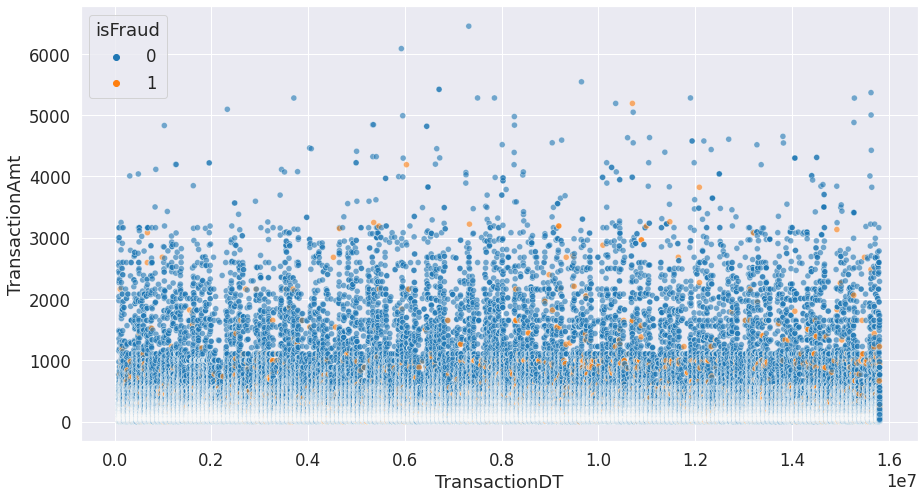

In [ ]:
with sns.plotting_context('notebook', font_scale=1.5), \
    sns.axes_style('darkgrid'):
    plt.figure(figsize=(15, 8))
    ax=sns.scatterplot(x='TransactionDT', y='TransactionAmt',\
                data=data,\
                hue='isFraud', alpha=0.6)

Что можно отметить. Частота мошеннических операций пропорционально частоте операций по суммам, т.е. операции с мелкими суммами встречаются чаще чем с круными, но появление мошеннической операции равновероятно как в группе операций с суммами до 1000 у.е., так и в группах 1000-2000 у.е., 2000-3000 у.е. и т.д.

##Подготовка данных

## Подготовка данных из первичных трейна и теста из гугл

In [ ]:
data_all.shape, data_train.shape, data_test.shape

In [ ]:
features_norm=(feature_label_norm+features_cat_norm+numeric_features_norm)
# features_norm.remove('krit')

In [ ]:
#X=data_train[features_norm].copy()

In [ ]:
X=data_train_full.drop(columns=feat_out)
X.dropna(how='all', inplace=True)

In [ ]:
X.shape

(590540, 425)

In [ ]:
y=X['isFraud']
X=X.drop(['isFraud'], axis=1)

In [ ]:
y.shape, X.shape

((590540, 1), (590540, 424))

In [ ]:
X_test=data_test.drop(columns=feat_out)


In [ ]:
f=features_norm.copy()
f.remove('isFraud')
X_test=data_test[f].copy()

In [ ]:
del data_train_full
gc.collect()

44

сохранение подготовленных наборов на диске

In [ ]:
#X.to_csv('/content/drive/MyDrive/Classroom/X_isFraud_01_02.csv', index=False)
#y.to_csv('/content/drive/MyDrive/Classroom/y_isFraud_01_02.csv', index=False)

In [ ]:
#X_test.to_csv('/content/drive/MyDrive/Classroom/X_test_isFraud_01_02.csv', index=False)

## Подготовка данных из предварительно сохраненных на диске предподготовленных. Удаление лишних колонок преобразование

In [ ]:
# del X
# del y
# del X_test
# gc.collect()

In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/X_isFraud_01_02.csv'
X = pd.read_csv(path_to_data)

In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/y_isFraud_01_02.csv'
y = pd.read_csv(path_to_data)

In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/X_test_isFraud_01_02.csv'
X_test = pd.read_csv(path_to_data)

In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/list_off_02_02.csv'
list_off= pd.read_csv(path_to_data)

In [ ]:
X.shape, X_test.shape, y.shape

((590540, 359), (506691, 359), (590540, 1))

In [ ]:
X.columns==X_test.columns

In [ ]:
column_to_int=['addr1', 'addr2', 'card2', 'card3', 'id_13','card5', 'id_14', 'id_17', 'id_18', 'id_19', 'id_20']

In [ ]:
for col in column_to_int:
  if X[col].dtype==np.float:
    X[col]=X[col].apply(lambda x: '{0:.0f}'.format(x))
  if X_test[col].dtype==np.float:
    X_test[col]=X_test[col].apply(lambda x: '{0:.0f}'.format(x))

In [ ]:
f=features_cat_itog.copy()
for col in feat_out:
  if col in f:
    f.remove(col)

In [ ]:
for col in f:
  X[col].replace('nan', ' ', inplace=True)
  X_test[col].replace('nan', ' ', inplace=True)

In [ ]:
X[column_to_int]

,addr1,addr2,card2,card3,id_13,card5,id_14,id_17,id_18,id_19,id_20
0,315,87,,150,,142,,,,,
1,325,87,404,150,,102,,,,,
2,330,87,490,150,,166,,,,,
3,476,87,567,150,,117,,,,,
4,420,87,514,150,,102,-480,166,,542,144
...,...,...,...,...,...,...,...,...,...,...,...
590535,272,87,,150,,226,,,,,
590536,204,87,225,150,,224,,,,,
590537,231,87,595,150,,224,,,,,
590538,387,87,481,150,,224,,,,,


In [ ]:
for col in f:
  X[col].fillna(' ', inplace=True)
  X_test[col].fillna(' ', inplace=True)

In [ ]:
X[feature_m]

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,,,
1,,,,M0,T,T,,,
2,T,T,T,M0,F,F,F,F,F
3,,,,M0,T,F,,,
4,,,,,,,,,
...,...,...,...,...,...,...,...,...,...
590535,T,T,T,M0,T,F,F,F,T
590536,T,F,F,M0,F,T,F,F,F
590537,T,F,F,,,T,,,
590538,T,T,T,M0,F,T,,,


Удаляем фичи list_off - это фичи не влияющие на результат по первым прогонам и имеющие высокую корреляцию

In [ ]:
list_off

,feature,importance
0,V17,0.0
1,V18,0.0
2,V21,0.0
3,V22,0.0
4,V31,0.0
...,...,...
63,V327,0.0
64,V329,0.0
65,V330,0.0
66,V333,0.0


In [ ]:
X.to_csv('/content/drive/MyDrive/Classroom/X_isFraud_02_02.csv', index=False)

In [ ]:
X_test.to_csv('/content/drive/MyDrive/Classroom/X_test_isFraud_02_02.csv', index=False)

In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/X_isFraud_02_02.csv'
X = pd.read_csv(path_to_data)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/X_test_isFraud_02_02.csv'
X_test = pd.read_csv(path_to_data)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
X.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V332,V334,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,card_card,dist,addr
0,2987000,86400,68.5,W,13926,,150,discover,142,credit,315,87,19.0,NaN,,,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,,,,,,,NaN,,,,,,,,,13926 150discovercredit142,19.0nan,31587
1,2987001,86401,29.0,W,2755,404,150,mastercard,102,credit,325,87,NaN,NaN,gmail.com,,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,,,,,,,NaN,,,,,,,,,2755404150mastercardcredit102,nannan,32587
2,2987002,86469,59.0,W,4663,490,150,visa,166,debit,330,87,287.0,NaN,outlook.com,,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,,,,,,,NaN,,,,,,,,,4663490150visadebit166,287.0nan,33087
3,2987003,86499,50.0,W,18132,567,150,mastercard,117,debit,476,87,NaN,NaN,yahoo.com,,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,,,,,,,NaN,,,,,,,,,18132567150mastercarddebit117,nannan,47687
4,2987004,86506,50.0,H,4497,514,150,mastercard,102,credit,420,87,NaN,NaN,gmail.com,,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,,-480,New,NotFound,166,,542,144,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,4497514150mastercardcredit102,nannan,42087


In [ ]:
list_off.feature.values

array(['V17', 'V18', 'V21', 'V22', 'V31', 'V39', 'V50', 'V59', 'V68',
       'V74', 'V84', 'V88', 'V89', 'V92', 'V101', 'V106', 'V113', 'V119',
       'V154', 'V155', 'V158', 'V167', 'V179', 'V180', 'V181', 'V182',
       'V183', 'V190', 'V200', 'V212', 'V213', 'V217', 'V228', 'V229',
       'V231', 'V232', 'V233', 'V235', 'V236', 'V237', 'V244', 'V245',
       'V246', 'V247', 'V248', 'V249', 'V252', 'V254', 'V255', 'V263',
       'V269', 'V273', 'V274', 'V276', 'V277', 'V278', 'V297', 'V298',
       'V299', 'V302', 'V304', 'V322', 'V325', 'V327', 'V329', 'V330',
       'V333', 'V335'], dtype=object)

In [ ]:
X=X.drop(columns=list_off.feature.values)

In [ ]:
X_test.drop(columns=list_off.feature.values, inplace=True)

In [ ]:
X.shape, X_test.shape

((590540, 356), (506691, 356))

Добавляем столбцы, где объединяем карты в одну строку, расстояние и адрес

In [ ]:
X['card_card']=X['card1'].astype(str)+\
                             X['card2'].astype(str) +\
                             X['card3'].astype(str)+\
                             X['card4']+X['card6']+\
                             X['card5'].astype(str)

In [ ]:
X_test['card_card']=X_test['card1'].astype(str)+\
                             X_test['card2'].astype(str) +\
                             X_test['card3'].astype(str)+\
                             X_test['card4']+X_test['card6']+\
                             X_test['card5'].astype(str)

In [ ]:
X['dist']=X['dist1'].astype(str)+X['dist2'].astype(str) 

In [ ]:
X_test['dist']=X_test['dist1'].astype(str)+X_test['dist2'].astype(str) 

In [ ]:
X['addr']=X['addr1'].astype(str)+X['addr2'].astype(str) 

In [ ]:
X_test['addr']=X_test['addr1'].astype(str)+X_test['addr2'].astype(str) 

#CatBoost

In [ ]:
!pip install -q catboost shap

     |████████████████████████████████| 76.1 MB 1.3 MB/s 
     |████████████████████████████████| 564 kB 36.9 MB/s 


In [ ]:
import catboost
from catboost import CatBoostRegressor

import shap
import sklearn.model_selection
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#feat_cat=feature_label_norm+features_cat_norm

In [ ]:
#features_cat_itog

In [ ]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y,
                                              test_size=0.25, random_state=42)

In [ ]:
f.extend(['card_card', 'dist', 'addr'])

In [ ]:
X_train[0:2]

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V326,V328,V331,V332,V334,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
139425,3126425,2845652,87.0,W,10847,302.0,150.0,visa,226.0,credit,325.0,87.0,NaN,NaN,anonymous.com,NaN,139.0,118.0,0.0,0.0,86.0,93.0,0.0,0.0,82.0,0.0,99.0,0.0,410.0,112.0,512.0,512.0,1.0,512.0,1.0,NaN,NaN,NaN,NaN,512.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151318,3138318,3112209,500.0,R,15446,460.0,150.0,mastercard,224.0,debit,226.0,87.0,NaN,NaN,aol.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,482734.0,NaN,NaN,0.0,0.0,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,166.0,NaN,529.0,299.0,New,NotFound,Windows 7,ie 11.0 for desktop,24.0,1600x900,match_status:2,T,F,T,T,desktop,Trident/7.0


In [ ]:
X.iloc[8, 408]

' '

In [ ]:
train_pool = catboost.Pool(
    X_train,
    label=y_train,
    cat_features=f
)
val_pool = catboost.Pool(
    X_validate,
    label=y_validate,
    cat_features=f
)
test_pool = catboost.Pool(
    X_test,
    cat_features=f
)

In [ ]:
!rm -rf 'catboost_clf_find_fraud/snapshot.bkp'

In [ ]:
catboost_train_dir = 'catboost_clf_find_fraud'
clf = catboost.CatBoostClassifier(
    eval_metric='AUC',
    od_pval=0.05,
    od_wait=20,
    # early_stopping_rounds=20,
    random_seed=52,
    train_dir=catboost_train_dir,
    task_type='CPU',
    # task_type='GPU',
    # devices='0',
    auto_class_weights='Balanced',
    use_best_model=True
)
clf.fit(
    train_pool, 
    eval_set=val_pool,
    plot=True,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.142741
0:	test: 0.8262686	best: 0.8262686 (0)	total: 5.91s	remaining: 1h 38m 28s
1:	test: 0.8411569	best: 0.8411569 (1)	total: 10.9s	remaining: 1h 30m 16s
2:	test: 0.8485803	best: 0.8485803 (2)	total: 16s	remaining: 1h 28m 48s
3:	test: 0.8655156	best: 0.8655156 (3)	total: 20.3s	remaining: 1h 24m 22s
4:	test: 0.8770436	best: 0.8770436 (4)	total: 26.3s	remaining: 1h 27m 15s
5:	test: 0.8931519	best: 0.8931519 (5)	total: 32.1s	remaining: 1h 28m 42s
6:	test: 0.8991236	best: 0.8991236 (6)	total: 37.4s	remaining: 1h 28m 18s
7:	test: 0.9027916	best: 0.9027916 (7)	total: 42.4s	remaining: 1h 27m 42s
8:	test: 0.9052136	best: 0.9052136 (8)	total: 47.2s	remaining: 1h 26m 39s
9:	test: 0.9121685	best: 0.9121685 (9)	total: 52.9s	remaining: 1h 27m 14s
10:	test: 0.9125357	best: 0.9125357 (10)	total: 58.3s	remaining: 1h 27m 18s
11:	test: 0.9202937	best: 0.9202937 (11)	total: 1m 4s	remaining: 1h 27m 58s
12:	test: 0.9215762	best: 0.9215762 (12)	total: 1m 9s	remaining: 1h 28m
13:	test

In [ ]:
vt_pool = catboost.Pool(
    X_validate,
    cat_features=f
    )  

tt_pool = catboost.Pool(
    X_train,
    cat_features=f
) 
y_pred_train = clf.predict(tt_pool)
y_pred_val = clf.predict(vt_pool)
y_pred_submit = clf.predict(test_pool)

Сохраняем результат сразу же

In [ ]:
y_pred_submit_res=pd.DataFrame(zip(X_test.TransactionID, y_pred_submit), columns=['TransactionID', 'isFraud'])

In [ ]:
y_pred_submit_res

,TransactionID,isFraud
0,3663549,0
1,3663550,0
2,3663551,0
3,3663552,0
4,3663553,0
...,...,...
506686,4170235,0
506687,4170236,0
506688,4170237,0
506689,4170238,0


In [ ]:
y_pred_submit_res.to_csv('/content/drive/MyDrive/Classroom/submit_isFraud_01_02.csv', index=False)

In [ ]:
rez1= pd.read_csv('/content/drive/MyDrive/Classroom/submit_isFraud_31_01.csv')

График первого обучения

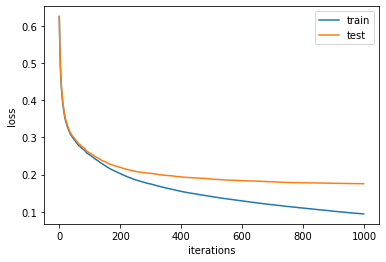

In [ ]:
# hist = clf.get_evals_result()
# plt.plot(list(hist['learn'].values())[0], label= 'train')
# plt.plot(list(hist['validation'].values())[0], label = 'test')
# plt.ylabel('loss')
# plt.xlabel('iterations')
# plt.legend()
# plt.show()

График второго обучения

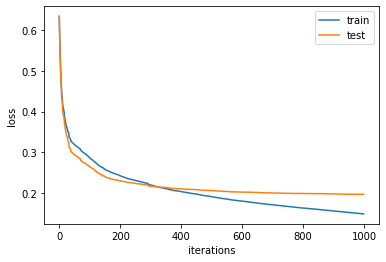

In [ ]:
# hist = clf.get_evals_result()
# plt.plot(list(hist['learn'].values())[0], label= 'train')
# plt.plot(list(hist['validation'].values())[0], label = 'test')
# plt.ylabel('loss')
# plt.xlabel('iterations')
# plt.legend()
# plt.show()

График третьего обучения

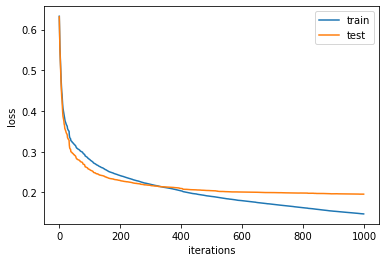

In [ ]:
hist = clf.get_evals_result()
plt.plot(list(hist['learn'].values())[0], label= 'train')
plt.plot(list(hist['validation'].values())[0], label = 'test')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()
plt.show()

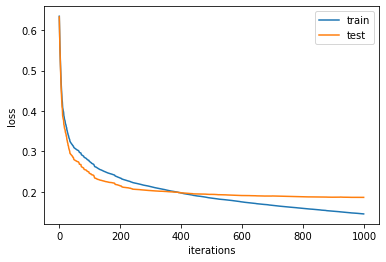

In [ ]:
hist = clf.get_evals_result()
plt.plot(list(hist['learn'].values())[0], label= 'train')
plt.plot(list(hist['validation'].values())[0], label = 'test')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()
plt.show()

In [ ]:
feature_import=sorted(
    zip(X_train.columns, clf.feature_importances_), 
    key=lambda p: p[1], 
    reverse=True
)

Важность фичей первой попытки

In [ ]:
# feature_import

[('TransactionAmt', 5.034974644484741),
 ('C1', 5.028676959795606),
 ('TransactionID', 4.390474718065927),
 ('id_20', 3.4534343953667364),
 ('D8', 3.328604969001422),
 ('card1', 3.2977863390173394),
 ('C13', 2.973324240119028),
 ('card3', 2.749922171198177),
 ('id_31', 2.5378199068917833),
 ('C14', 2.5134367921123877),
 ('id_19', 2.5081382413545565),
 ('R_emaildomain', 2.4822114414783263),
 ('card2', 2.4371147765587016),
 ('id_02', 2.3441977603466664),
 ('ProductCD', 2.2473486162174146),
 ('TransactionDT', 2.1418770826774103),
 ('D2', 1.9795691902825545),
 ('DeviceInfo', 1.9249361134600156),
 ('P_emaildomain', 1.3696798325608806),
 ('card6', 1.3310647188377425),
 ('C11', 1.253229597212994),
 ('id_06', 1.1725555263561092),
 ('D13', 1.107378794018998),
 ('addr1', 1.0985029920369491),
 ('id_05', 1.0832783802944397),
 ('D14', 1.0201795959214073),
 ('card5', 1.0121180346446126),
 ('id_33', 0.886176791855844),
 ('id_30', 0.8223077533999621),
 ('dist2', 0.8184570786844175),
 ('C2', 0.80711250

Важность фичей сторой попытки

In [ ]:
feature_import

[('card1', 6.793613566558534),
 ('TransactionAmt', 4.716887542238152),
 ('addr1', 4.192885281319392),
 ('C13', 3.768941623118554),
 ('card2', 3.4752336526354455),
 ('D2', 2.9966051428059157),
 ('D10', 2.7341537308643584),
 ('P_emaildomain', 2.707117269130512),
 ('TransactionID', 2.5260028137951864),
 ('C1', 2.512370703663343),
 ('TransactionDT', 2.2763538493354787),
 ('D15', 2.133617439947016),
 ('D11', 2.0373085615373547),
 ('C6', 1.8731780149544264),
 ('D1', 1.8424305330457793),
 ('M5', 1.8126722305380365),
 ('dist1', 1.7253459921919494),
 ('D4', 1.5049908020610343),
 ('C14', 1.4980110761819163),
 ('M6', 1.4941201768393575),
 ('card5', 1.4460914622549503),
 ('M4', 1.4109277753085883),
 ('C9', 1.3987504966146043),
 ('D3', 1.397951627470358),
 ('C2', 1.323664171760611),
 ('C5', 1.3084117630936818),
 ('D5', 1.2393541161663237),
 ('V91', 1.1051920389073484),
 ('V90', 0.8117844172626123),
 ('C11', 0.7857758360991497),
 ('id_19', 0.7729619516023242),
 ('DeviceInfo', 0.7688642130212572),
 (

In [ ]:
#Фичи импотанс после третьей
feature_import

,feature,importance
0,card1,7.270665
1,TransactionAmt,4.684489
2,addr1,4.161258
3,C13,3.355992
4,D2,3.302357
...,...,...
351,V251,0.000000
352,V288,0.000000
353,V305,0.000000
354,V323,0.000000


In [ ]:
feature_import=pd.DataFrame(feature_import, columns=['feature', 'importance'])

In [ ]:
feature_import.to_csv('/content/drive/MyDrive/Classroom/feature_import_02_02.csv', index=False)

In [ ]:
shap_info = clf.get_feature_importance(
    data=train_pool, 
    type='ShapValues', 
    verbose=10000
)
shap_values = shap_info[:,:-1]
base_values = shap_info[:,-1]

Первая попытка

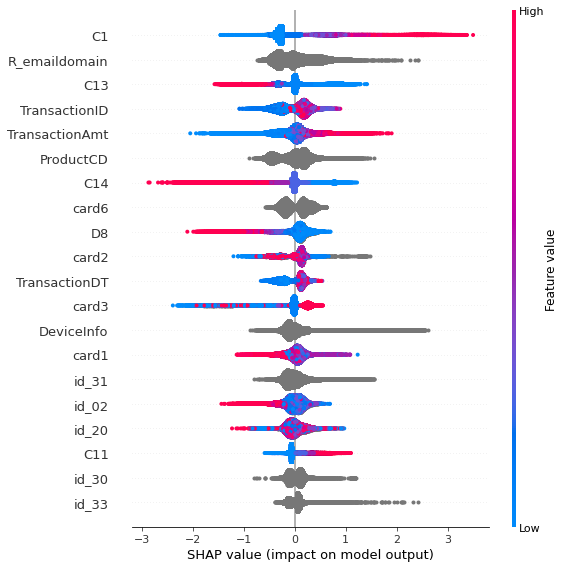

In [ ]:
# shap.summary_plot(shap_values, X_train)